In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay


In [2]:
# Load Breast‑Cancer Wisconsin dataset
data   = load_breast_cancer()
X_raw  = data.data                # (569, 30)
y_raw  = data.target.reshape(-1, 1)

# Train / validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_raw, y_raw, test_size=0.20, random_state=42, stratify=y_raw)

# Standardise (important for NN)
scaler  = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val   = scaler.transform(X_val)

print("Train shape:", X_train.shape, "  Val shape:", X_val.shape)


Train shape: (455, 30)   Val shape: (114, 30)


In [3]:
def relu(z):            return np.maximum(0, z)
def relu_deriv(a):      return (a > 0).astype(float)

def sigmoid(z):         return 1 / (1 + np.exp(-z))

def bce(y, yhat, eps=1e-8):
    return -np.mean(y*np.log(yhat+eps) + (1-y)*np.log(1-yhat+eps))


In [4]:
class NeuralNN:
    def __init__(self, layers, lr=0.01, l2=1e-4, epochs=200, batch=32, seed=42):
        np.random.seed(seed)
        self.lr, self.l2, self.epochs, self.batch = lr, l2, epochs, batch
        self.W, self.b = [], []
        for m, n in zip(layers[:-1], layers[1:]):
            self.W.append(np.random.randn(m, n) * np.sqrt(2/m))  # He init
            self.b.append(np.zeros((1, n)))
        self.loss_hist = []

    # forward pass ----------------------------------------------------------
    def _forward(self, X):
        A, Z = [X], []
        for i, (W, b) in enumerate(zip(self.W, self.b)):
            Z_i = A[-1] @ W + b
            A_i = sigmoid(Z_i) if i == len(self.W)-1 else relu(Z_i)
            Z.append(Z_i); A.append(A_i)
        return A, Z

    # backward pass (vectorised) -------------------------------------------
    def _backward(self, A, Z, y):
        m = y.shape[0]
        dA = A[-1] - y                       # (m,1)
        for i in reversed(range(len(self.W))):
            if i == len(self.W)-1:           # output layer (sigmoid)
                dZ = dA * (A[-1] * (1 - A[-1]))
            else:                            # hidden (ReLU)
                dZ = dA * relu_deriv(A[i+1])
            dW =  A[i].T @ dZ / m + self.l2 * self.W[i]
            db =  np.mean(dZ, axis=0, keepdims=True)
            dA =  dZ @ self.W[i].T
            self.W[i] -= self.lr * dW
            self.b[i] -= self.lr * db

    # training loop ---------------------------------------------------------
    def fit(self, X, y, X_val=None, y_val=None, verbose=20):
        m = X.shape[0]
        for epoch in range(self.epochs):
            idx = np.random.permutation(m)
            for start in range(0, m, self.batch):
                batch = idx[start:start+self.batch]
                A, Z = self._forward(X[batch])
                self._backward(A, Z, y[batch])
            # track loss
            yhat = self._forward(X)[0][-1]
            loss = bce(y, yhat)
            self.loss_hist.append(loss)
            if verbose and epoch % verbose == 0:
                msg = f"Epoch {epoch:4d} | loss {loss:.4f}"
                if X_val is not None:
                    acc = accuracy_score(y_val, self.predict(X_val))
                    msg += f" | val acc {acc:.3f}"
                print(msg)

    # inference -------------------------------------------------------------
    def predict_proba(self, X):
        return self._forward(X)[0][-1]

    def predict(self, X, thresh=0.5):
        return (self.predict_proba(X) >= thresh).astype(int)


In [5]:
net = NeuralNN(layers=[30, 16, 8, 1], lr=0.01, epochs=300, batch=32)
net.fit(X_train, y_train, X_val, y_val, verbose=20)


Epoch    0 | loss 0.6847 | val acc 0.623
Epoch   20 | loss 0.4344 | val acc 0.842
Epoch   40 | loss 0.3171 | val acc 0.886
Epoch   60 | loss 0.2506 | val acc 0.921
Epoch   80 | loss 0.2097 | val acc 0.939
Epoch  100 | loss 0.1832 | val acc 0.956
Epoch  120 | loss 0.1645 | val acc 0.956
Epoch  140 | loss 0.1503 | val acc 0.965
Epoch  160 | loss 0.1391 | val acc 0.956
Epoch  180 | loss 0.1301 | val acc 0.956
Epoch  200 | loss 0.1224 | val acc 0.965
Epoch  220 | loss 0.1159 | val acc 0.965
Epoch  240 | loss 0.1107 | val acc 0.965
Epoch  260 | loss 0.1063 | val acc 0.965
Epoch  280 | loss 0.1024 | val acc 0.974


In [6]:
y_prob = net.predict_proba(X_val)
y_pred = net.predict(X_val)

print("Validation accuracy :", accuracy_score(y_val, y_pred))
print("Validation ROC‑AUC  :", roc_auc_score(y_val, y_prob))


Validation accuracy : 0.9736842105263158
Validation ROC‑AUC  : 0.9953703703703705


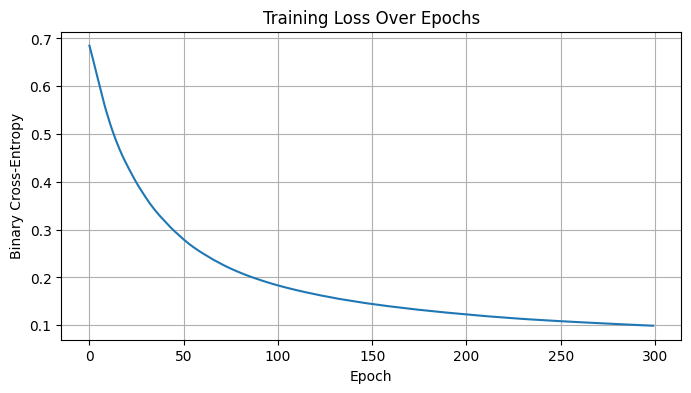

In [7]:
plt.figure(figsize=(8,4))
plt.plot(net.loss_hist)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross‑Entropy")
plt.grid(True)
plt.show()


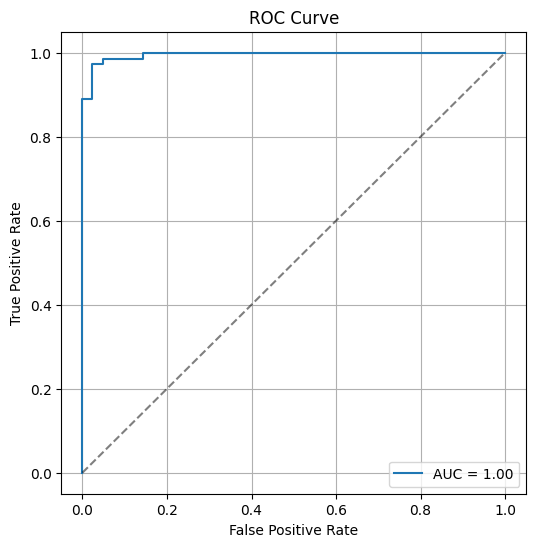

In [8]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


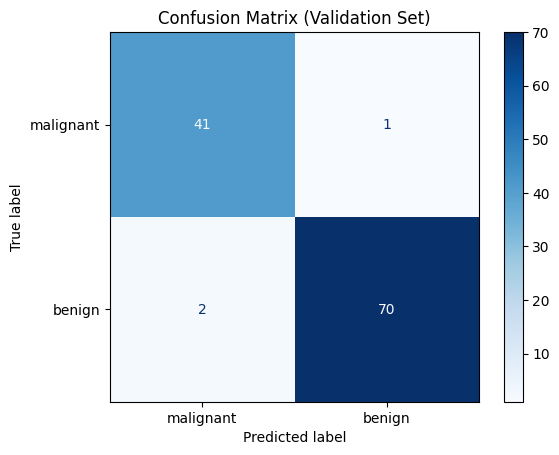

In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=data.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.grid(False)
plt.show()
